Map Hardiness zones to cultivars

Reference:
-  https://en.wikipedia.org/wiki/Hardiness_zone
- https://planthardiness.ars.usda.gov/

In [194]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
# apples
apple_cultivars = pd.read_csv('../data/processed/starkbros_apples.csv')

# starting region
orchards_shape_file_path = "../data/processed/gdf_easternmountain_polygons/gdf_easternmountain_polygons.shp"
east_orchards_gdf = gpd.read_file(orchards_shape_file_path)

# read states

states = gpd.read_file('../data/external/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states = states.to_crs("EPSG:4326") 

east = states[states['STUSPS'].isin(['VA','NC','WV','MD','PA'])]

# read ground truth 

ground_truth = pd.read_csv('../data/external/test_era5/oiko_easternmountain.csv')
ground_truth['time'] = pd.to_datetime(ground_truth['time'])

In [114]:
# Pre-Processing:

apple_cultivars['Min_zone'] = apple_cultivars['Zone Range'].apply(lambda x: int(x[0]))
apple_cultivars['Max_zone'] = apple_cultivars['Zone Range'].apply(lambda x: int(x[-1]))
apple_cultivars.rename(columns = {'Unnamed: 0':'Apple'}, inplace=True)

apple_cultivars.set_index('Apple', inplace= True)

In [80]:
def filter_on_window(df, window_size):

    # filter by window for USDA:

    min_year = df['time'].dt.year.min()
    max_year = df['time'].dt.year.max()

    if max_year - min_year < window_size:
        cut_off = max_year

    else:
        cut_off = min_year + window_size

    payload = df[(df['time'].dt.year >= min_year) & (df['time'].dt.year <= cut_off)]

    return payload

In [81]:
ground_truth = filter_on_window(ground_truth, 20)

In [110]:
gt_gb = ground_truth.groupby(['latitude','longitude'])['temperature'].min().to_frame()

# rename col
gt_gb.rename(columns={'temperature':'Min Temperature'}, inplace = True)

In [120]:
# can definitely shortern the statement by using modular division.
def assign_usda(t):
    # in Fahrenheit
    # source: https://en.wikipedia.org/wiki/Hardiness_zone
    if t > 60:
        return 13
    elif t > 50:
        return 12
    elif t > 40:
        return 11
    elif t > 30:
        return 10
    elif t > 20:
        return 9
    elif t > 10:
        return 8
    elif t > 0:
        return 7
    elif t > -10:
        return 6
    elif t > -20:
        return 5
    elif t > -30:
        return 4
    elif t > -40:
        return 3
    elif t > -50:
        return 2
    elif t > -60:
        return 1
    else:
        return 0

In [121]:
gt_gb['USDA_zone'] = gt_gb['Min Temperature'].apply(assign_usda)

In [146]:
# Add Encoding
for apple in apple_cultivars.index:
    gt_gb[apple] = False

In [183]:
# Assign Cultivars

for index, row in gt_gb.iterrows():

    for apple in apple_cultivars.index:
        if row.USDA_zone >= apple_cultivars.loc[apple].Min_zone and row.USDA_zone <= apple_cultivars.loc[apple].Max_zone:
            gt_gb.loc[index, apple] = True
            #print(f'for {apple} on {index} with {row.USDA_zone}, it can be grown with {apple_cultivars.loc[apple].Min_zone}-{apple_cultivars.loc[apple].Max_zone}')

In [186]:
# Payload
gt_gb.head()

Min Temperature  USDA_zone  ambrosia-apple  \
latitude longitude                                               
35.25    -83.75          -20.284515          4            True   
         -83.50          -20.468277          4            True   
         -83.25          -20.547958          4            True   
         -83.00          -20.770767          4            True   
         -82.75          -19.087585          5            True   

                    apple-babe-genetic-dwarf-apple  baldwin-apple  \
latitude longitude                                                  
35.25    -83.75                               True           True   
         -83.50                               True           True   
         -83.25                               True           True   
         -83.00                               True           True   
         -82.75                               True           True   

                    ben-davis-apple  braeburn-apple  buckeye-gala-apple  \
latitude longitude                                                        
35.25    -83.75                True           False               False   
         -83.50                True           False               False   
         -83.25                True           False               False   
         -83.00                True           False               False   
         -82.75                True            True                True   

                    candycrisp-apple  chenango-strawberry-apple  ...  \
latitude longitude                                               ...   
35.25    -83.75                 True                       True  ...   
         -83.50                 True                       True  ...   
         -83.25                 True                       True  ...   
         -83.00                 True                       True  ...   
         -82.75                 True                       True  ...   

                    summer-rambo-apple  wealthy-apple  whitney-crabapple  \
latitude longitude                                                         
35.25    -83.75                   True           True               True   
         -83.50                   True           True               True   
         -83.25                   True           True               True   
         -83.00                   True           True               True   
         -82.75                   True           True               True   

                    wiltons-red-jonaprince-apple  winecrisp-apple  \
latitude longitude                                                  
35.25    -83.75                             True             True   
         -83.50                             True             True   
         -83.25                             True             True   
         -83.00                             True             True   
         -82.75                             True             True   

                    wolf-river-apple  yellow-transparent-apple  \
latitude longitude                                               
35.25    -83.75                 True                      True   
         -83.50                 True                      True   
         -83.25                 True                      True   
         -83.00                 True                      True   
         -82.75                 True                      True   

                    york-imperial-apple  zestar-apple  \
latitude longitude                                      
35.25    -83.75                    True          True   
         -83.50                    True          True   
         -83.25                    True          True   
         -83.00                    True          True   
         -82.75                    True          True   

                    starkspur-winter-banana-antique-apple  
latitude longitude                                         
35.25    -83.75                           

In [189]:
# convert to Geopandas
gt_gb_temp = gt_gb.copy()

gt_gb_temp = gt_gb_temp.reset_index(['latitude','longitude'])

# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
gt_gpd = gpd.GeoDataFrame(gt_gb_temp, geometry= gpd.points_from_xy(gt_gb_temp.longitude, gt_gb_temp.latitude), crs="EPSG:4326"
)


In [190]:
gt_gpd 

,latitude,longitude,Min Temperature,USDA_zone,ambrosia-apple,apple-babe-genetic-dwarf-apple,baldwin-apple,ben-davis-apple,braeburn-apple,buckeye-gala-apple,...,wealthy-apple,whitney-crabapple,wiltons-red-jonaprince-apple,winecrisp-apple,wolf-river-apple,yellow-transparent-apple,york-imperial-apple,zestar-apple,starkspur-winter-banana-antique-apple,geometry
0,35.25,-83.75,-20.284515,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-83.75000 35.25000)
1,35.25,-83.50,-20.468277,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-83.50000 35.25000)
2,35.25,-83.25,-20.547958,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-83.25000 35.25000)
3,35.25,-83.00,-20.770767,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-83.00000 35.25000)
4,35.25,-82.75,-19.087585,5,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,POINT (-82.75000 35.25000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,39.50,-78.75,-26.843231,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-78.75000 39.50000)
275,39.50,-78.50,-23.257324,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-78.50000 39.50000)
276,39.50,-78.25,-21.669998,4,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,POINT (-78.25000 39.50000)
277,39.50,-78.00,-18.279999,5,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,POINT (-78.00000 39.50000)


Text(48.338895912556296, 0.5, 'Latitude [Degrees North]')

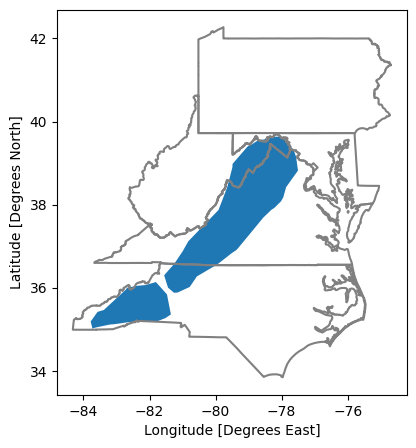

In [198]:
us_boundary_map = east.boundary.plot(figsize=(5, 5), color="Gray")
east_orchards_gdf.plot(ax = us_boundary_map)
plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Latitude [Degrees North]')

<Axes: >

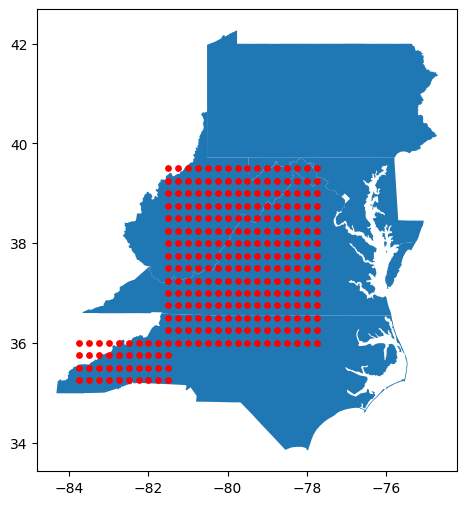

In [196]:
# Ground Truth Region
gt_gpd.plot(ax=east.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)